## Exploratory Data Analysis (EDA) – Anime Recommender System

#### Introduction
This notebook explores the anime and user ratings datasets, which will be sued to develop a *Hybird recommender system*. The goal of the analysis is to understand teh structure and quality of the data before building the recommendation models.



The key objectives of this notebook are :
- Loading and inspecting the *anime.csv* and *rating.csv* datasets
- Identify *missing values* and *outliers* within the data
- Explore *user behavior* by analysing rating distributions and activity levels
- Explore the *anime charactaristics* such as the genre, popularity and average ratings
- Prepare insights that will guide the design

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load datasets

anime_df = pd.read_csv("data/anime.csv")
ratings_df = pd.read_csv("data/rating.csv")

print(anime_df.head())
print(ratings_df.head())

print(f"Anime dataset: {anime_df.shape}")
print(f"Ratings dataset: {ratings_df.shape}")

print(anime_df.describe())




   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  
   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4

#### Data Cleaning

Before analysing the data, I ensured that datasets are consistent.

Anime dataset :
- Converted *rating*, *episodes* and *members* columns into numeric types.
- missing ratings were removed

Rating dataset :
- Converted the *rating* column into numeric format.
- Removed the entries where a rating was not provided (when the rating was -1)

In [34]:
# Data cleaning for anime dataset

anime_df['rating'] = pd.to_numeric(anime_df['rating'], errors='coerce')
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
anime_df['members'] = pd.to_numeric(anime_df['members'], errors='coerce')
anime_clean = anime_df.dropna(subset=['rating']).copy()
anime_clean = anime_clean[~anime_clean['genre'].str.contains('Hentai', case=False, na=False)].copy()
print(f"Anime dataset : {len(anime_df)} converted to {len(anime_clean)} entries!")

# Data cleaning for ratings dataset

ratings_df['rating'] = pd.to_numeric(ratings_df['rating'], errors='coerce')
ratings_clean = ratings_df[(ratings_df['rating'] != -1) & (ratings_df['rating'].notna())].copy()

print(f"Ratings dataset : {len(ratings_df)} converted to {len(ratings_clean)} entries!")

Anime dataset : 12294 converted to 10931 entries!
Ratings dataset : 7813737 converted to 6337241 entries!


### Merging Datasets

To prepare the data for analysis, we combined the *anime dataset* with the *ratings dataset*. I performed an inner join on the shared *anime_id*, ensuring that only anime present in both datasets were merged.

In [18]:
# Merging datasets

df = ratings_clean.merge(anime_clean, on='anime_id', how='inner')

print(f"Merged anime and ratings dataset, completed dataframe shape : {df.shape}")


Merged anime and ratings dataset, completed dataframe shape : (6337234, 9)


In [19]:
print(f"Total unique users: {ratings_clean['user_id'].nunique():,}")
print(f"Total unique anime: {ratings_clean['anime_id'].nunique():,}")
print(f"Total ratings: {len(ratings_clean):,}")
print(f"Average user ratings per user: {len(ratings_clean) / ratings_clean['user_id'].nunique():.1f}")
print(f"Average ratings per anime: {len(ratings_clean) / ratings_clean['anime_id'].nunique():.1f}")
print(f"Rating range: {ratings_clean['rating'].min()} - {ratings_clean['rating'].max()}")
print(f"Sparsity: {(1 - len(ratings_clean) / (ratings_clean['user_id'].nunique() * ratings_clean['anime_id'].nunique())) * 100:.2f}%")

Total unique users: 69,600
Total unique anime: 9,927
Total ratings: 6,337,241
Average user ratings per user: 91.1
Average ratings per anime: 638.4
Rating range: 1 - 10
Sparsity: 99.08%


### Exploratory Data Analysis

Now that the datasets are cleaned and merged, we explore the underlying patterns in anime ratings, user behavior, and anime attributes

### 1. User Rating Distribution  
**Reason:**  
This plot shows the overall distribution of user ratings across the dataset. It helps us understand how users typically score anime — whether they tend to rate generously (higher scores) or critically (lower scores).  

**Insights:**  
- Higher ratings are very common, this shows that many users tend to rate the anime that they enjoyed watching rather than the anime they disliked.
- The distribution is very skewed with a very small frequency of ratings below 4.

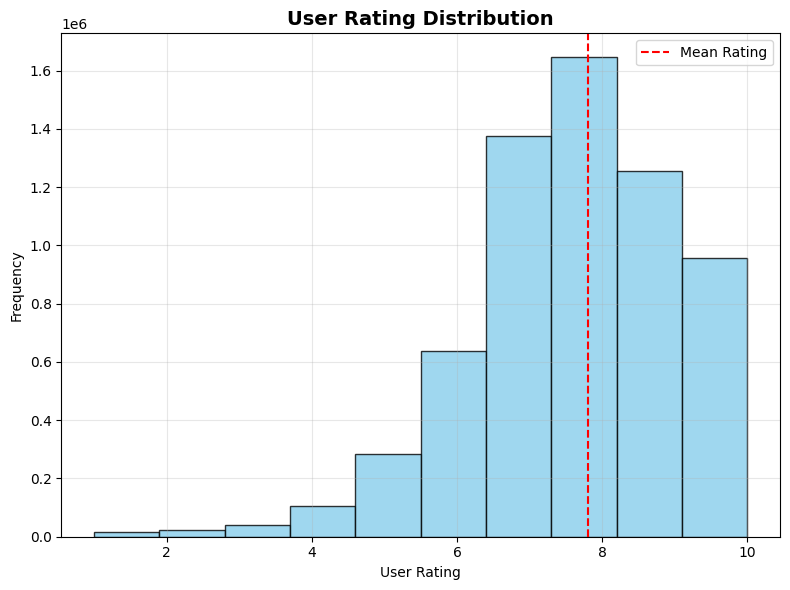

In [21]:
plt.figure(figsize=(8,6))
plt.hist(ratings_clean['rating'], bins=10, alpha=0.8, color="skyblue", edgecolor="black")
plt.axvline(ratings_clean['rating'].mean(), color="red", linestyle="--", label="Mean Rating")
plt.title("User Rating Distribution", fontsize=14, fontweight="bold")
plt.xlabel("User Rating")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("user_rating_distribution.png")
plt.show()

### 2. User Activity Distribution (Ratings per User)  
**Reason:**  
This graph explores how active users are in rating anime. Since many recommendation algorithms rely on user activity, identifying whether most users are casual or “power users” is crucial.  

**Insights:**  
- Most users rate < 100 anime hinting the fact that most users are casual watches of anime.

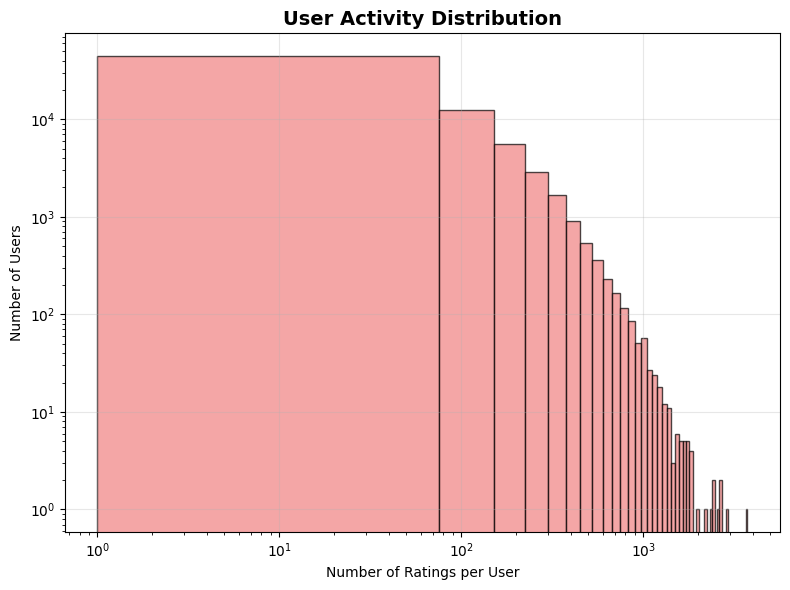

In [22]:
ratings_per_user = ratings_clean['user_id'].value_counts()
plt.figure(figsize=(8,6))
plt.hist(ratings_per_user, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.title("User Activity Distribution", fontsize=14, fontweight="bold")
plt.yscale("log")
plt.xscale("log")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("user_activity_distribution.png")
plt.show()

### 3. Anime Popularity Distribution (Ratings per Anime)  
**Reason:**  
This plot reveals how many ratings each anime has received. It highlights whether the dataset is dominated by a small number of popular anime or spread evenly.  

**Insights:**  
- Most anime have ratings below 1000.
- The handful of anime rating by huge numbers are blockbuster anime; Naruto, Death Note.


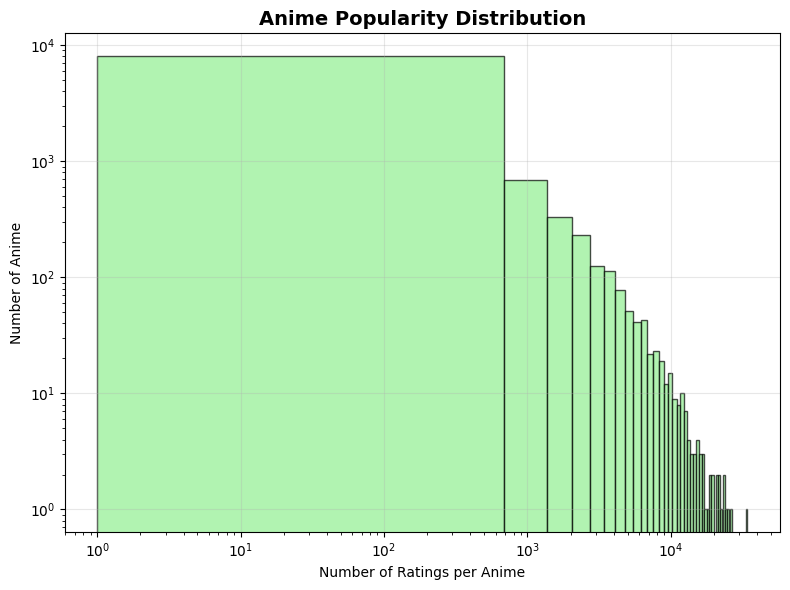

In [23]:
ratings_per_anime = ratings_clean['anime_id'].value_counts()
plt.figure(figsize=(8,6))
plt.hist(ratings_per_anime, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Ratings per Anime")
plt.ylabel("Number of Anime")
plt.title("Anime Popularity Distribution", fontsize=14, fontweight="bold")
plt.yscale("log")
plt.xscale("log")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("anime_popularity_distribution.png")
plt.show()

### 4. Top 10 Most Rated Anime  
**Reason:**  
Here we identify the most rated anime titles. This helps spot benchmark shows that many users engage with, which often become key anchors for recommender systems.  

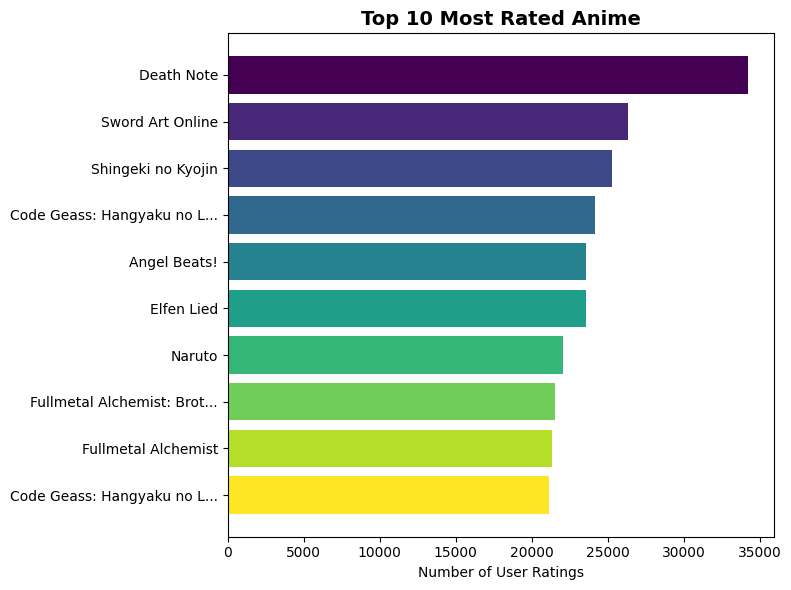

In [24]:
most_rated_anime_ids = ratings_per_anime.head(10)
most_rated_names = []
for anime_id in most_rated_anime_ids.index:
    name = anime_clean.loc[anime_clean['anime_id'] == anime_id, 'name'].iloc[0] \
        if len(anime_clean[anime_clean['anime_id'] == anime_id]) > 0 else f'Anime {anime_id}'
    most_rated_names.append(name[:25] + "..." if len(name) > 25 else name)

plt.figure(figsize=(8,6))
plt.barh(range(len(most_rated_names)), most_rated_anime_ids.values,
         color=plt.cm.viridis(np.linspace(0, 1, len(most_rated_names))))
plt.yticks(range(len(most_rated_names)), most_rated_names, fontsize=10)
plt.xlabel("Number of User Ratings")
plt.title("Top 10 Most Rated Anime", fontsize=14, fontweight="bold")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("top10_most_rated_anime.png")
plt.show()

### 5. User Ratings by Anime Type  
**Reason:**  
By analyzing ratings across anime types (TV, Movie, OVA, etc.), we see how user preferences differ by format. This is important for understanding whether recommender models should treat these categories differently.  

**Insights:**  
- Movies, Specials and TV are seen to be rated higher than other anime types, with Music and ONA being rated the lowest.
- OVA have the largest distribution of ratings ranging from 6-9.


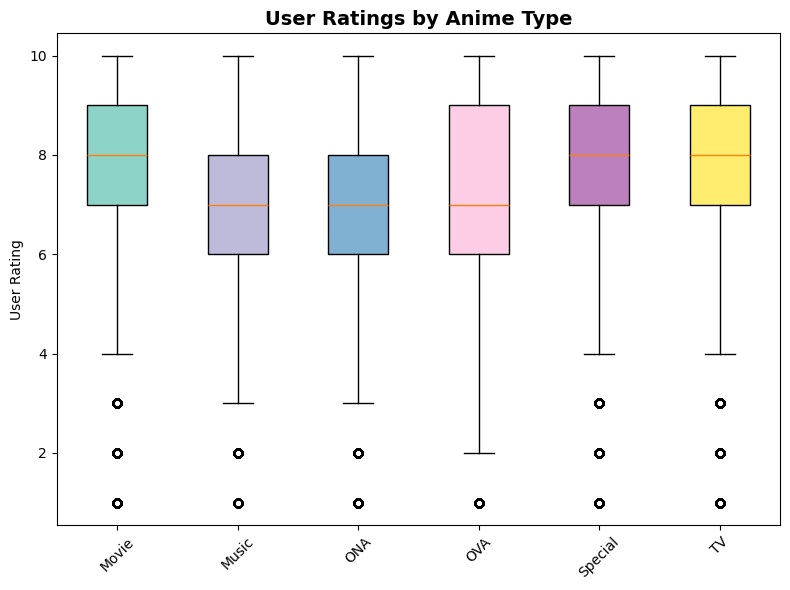

In [25]:
type_ratings = df.groupby("type")['rating_x'].apply(list).to_dict()
types_to_plot = [t for t in type_ratings.keys() if len(type_ratings[t]) >= 100]
box_data = [type_ratings[t] for t in types_to_plot]

plt.figure(figsize=(8,6))
box_plot = plt.boxplot(box_data, labels=types_to_plot, patch_artist=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(box_plot['boxes'])))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel("User Rating")
plt.title("User Ratings by Anime Type", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("ratings_by_anime_type.png")
plt.show()

### 6. Official vs User Ratings Correlation  
**Reason:**  
This scatterplot compares MyAnimeList’s official ratings with the average ratings given by users in our dataset. The correlation helps validate whether user opinions align with the platform’s aggregate scores.  

**Insights:**  
- The correlation coeffiecient is more than 0.8
- There are a clear number of anime rated 10 by users but are officially rated lower, showing a bias to certain anime.
- User ratings can be trusted, with some slight bias.

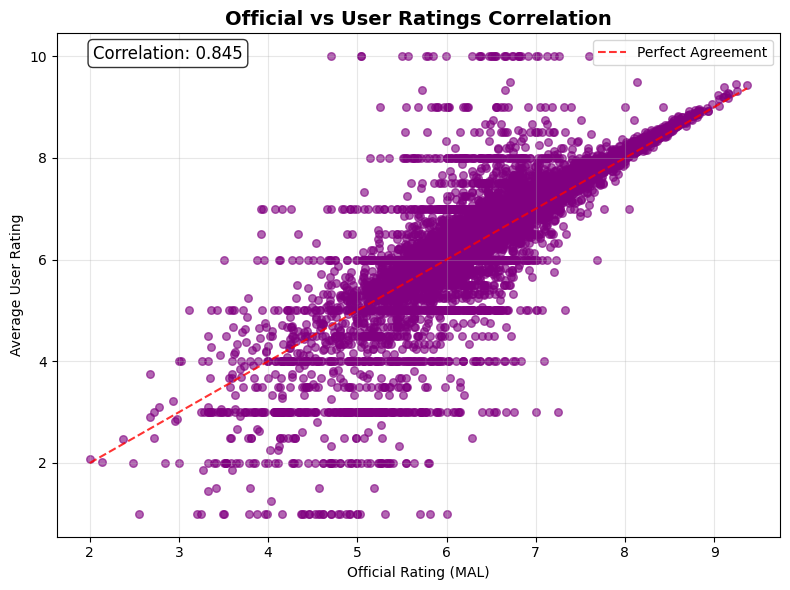

In [26]:
avg_user_ratings = ratings_clean.groupby('anime_id')['rating'].mean()
comparison_df = anime_clean.merge(avg_user_ratings.to_frame('avg_user_rating'),
                                  left_on='anime_id', right_index=True, how='inner')

plt.figure(figsize=(8,6))
plt.scatter(comparison_df['rating'], comparison_df['avg_user_rating'],
            alpha=0.6, s=30, c='purple')
plt.plot([comparison_df['rating'].min(), comparison_df['rating'].max()],
         [comparison_df['rating'].min(), comparison_df['rating'].max()],
         'r--', alpha=0.8, label="Perfect Agreement")
plt.xlabel("Official Rating (MAL)")
plt.ylabel("Average User Rating")
plt.title("Official vs User Ratings Correlation", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)
correlation = comparison_df['rating'].corr(comparison_df['avg_user_rating'])
plt.text(0.05, 0.95, f"Correlation: {correlation:.3f}", transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.8), fontsize=12)
plt.tight_layout()
plt.savefig("official_vs_user_ratings.png")
plt.show()

### 7. Rating Patterns of Top 20 Users (Heatmap)  
**Reason:**  
The heatmap visualizes rating tendencies of highly active users. This reveals whether certain users consistently rate high/low or use the full rating scale.  

**Insights:**  
- Most users are quite critical of their reviews.


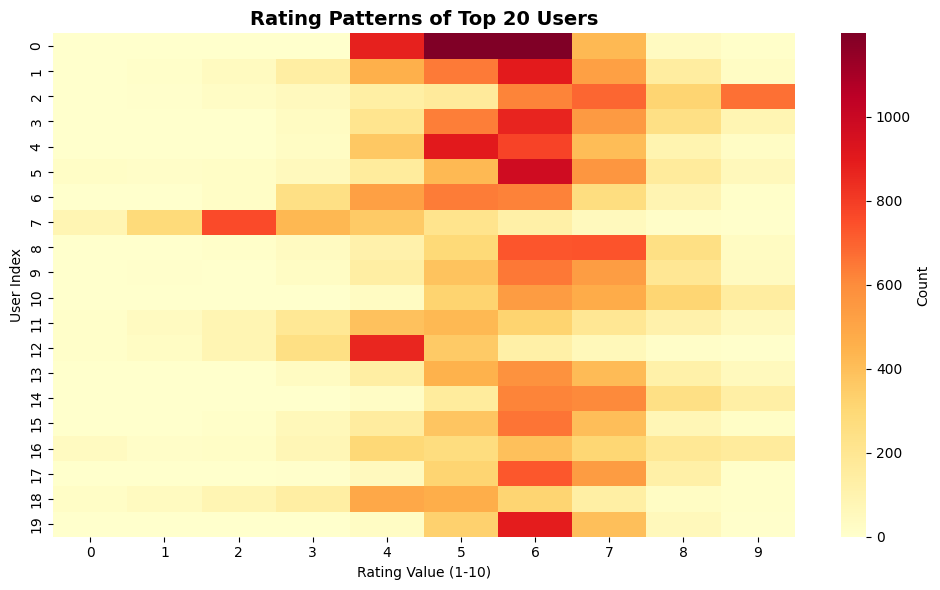

In [27]:
sample_users = ratings_clean['user_id'].value_counts().head(50).index
user_rating_patterns = []
for user in sample_users[:20]:
    user_ratings = ratings_clean[ratings_clean['user_id'] == user]['rating']
    rating_dist = [sum(user_ratings == i) for i in range(1, 11)]
    user_rating_patterns.append(rating_dist)

plt.figure(figsize=(10,6))
sns.heatmap(user_rating_patterns, cmap="YlOrRd", cbar_kws={'label': 'Count'})
plt.xlabel("Rating Value (1-10)")
plt.ylabel("User Index")
plt.title("Rating Patterns of Top 20 Users", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("user_behavior_heatmap.png")
plt.show()


### 8. User Segmentation for Cold Start Analysis  
**Reason:**  
This segmentation highlights new users (few ratings), active users, and power users. Cold-start issues arise when new users lack enough ratings for personalization — so quantifying this is key.  

**Insights:**  
- There are significantly more power and active users which is great for collaborative filtering.
- This data is useful for supporting new users.


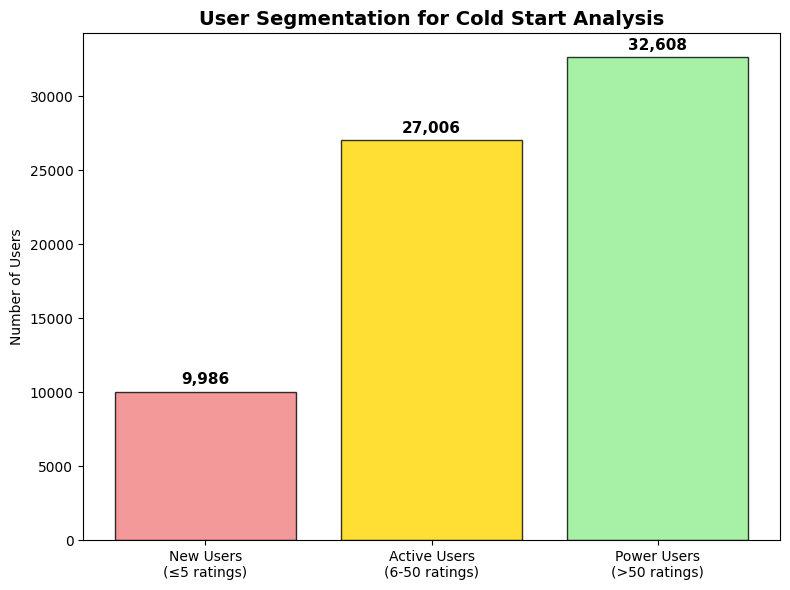

In [28]:
user_rating_counts = ratings_clean['user_id'].value_counts()
new_users = user_rating_counts[user_rating_counts <= 5]
established_users = user_rating_counts[user_rating_counts > 50]

categories = ["New Users\n(≤5 ratings)", "Active Users\n(6-50 ratings)", "Power Users\n(>50 ratings)"]
counts = [len(new_users), len(user_rating_counts) - len(new_users) - len(established_users), len(established_users)]
colors = ["lightcoral", "gold", "lightgreen"]

plt.figure(figsize=(8,6))
bars = plt.bar(categories, counts, color=colors, alpha=0.8, edgecolor="black")
plt.title("User Segmentation for Cold Start Analysis", fontsize=14, fontweight="bold")
plt.ylabel("Number of Users")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(counts) * 0.01,
             f"{int(height):,}", ha="center", va="bottom", fontsize=11, fontweight="bold")
plt.tight_layout()
plt.savefig("cold_start_user_segmentation.png")
plt.show()

### 9. User Preferences by Genre  
**Reason:**  
This analysis shows the average rating across genres (with a minimum rating threshold). It helps identify which genres are consistently well-received and which underperform.  


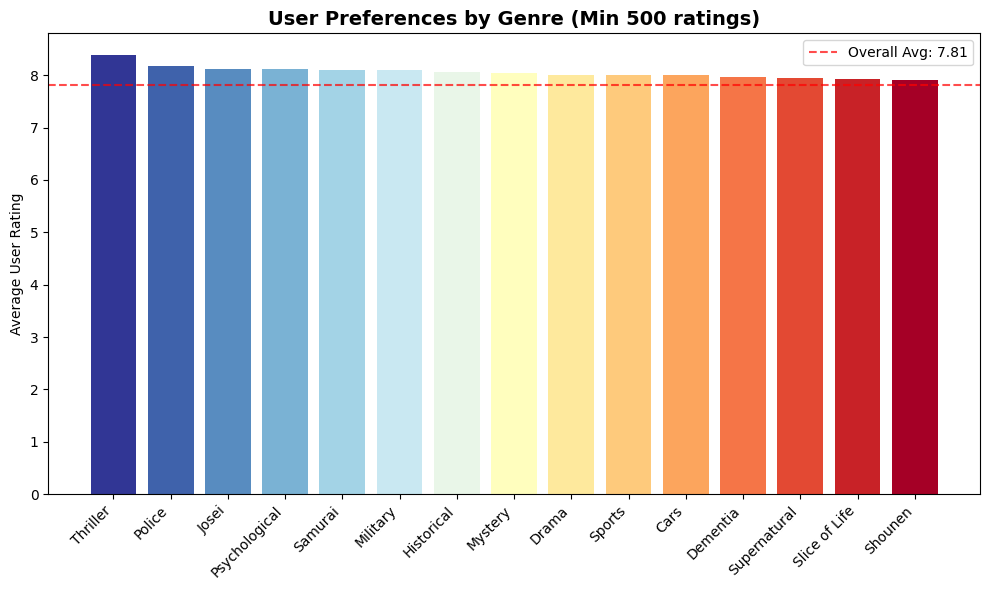

In [29]:
genre_user_ratings = {}
for idx, row in df.iterrows():
    if pd.notna(row['genre']):
        genres = [g.strip() for g in str(row['genre']).split(',')]
        for genre in genres:
            genre_user_ratings.setdefault(genre, []).append(row['rating_x'])

avg_genre_ratings = {genre: np.mean(ratings) for genre, ratings in genre_user_ratings.items()
                     if len(ratings) >= 500}
sorted_genre_ratings = sorted(avg_genre_ratings.items(), key=lambda x: x[1], reverse=True)

if sorted_genre_ratings:
    genres, ratings = zip(*sorted_genre_ratings[:15])
    plt.figure(figsize=(10,6))
    bars = plt.bar(range(len(genres)), ratings,
                   color=plt.cm.RdYlBu_r(np.linspace(0, 1, len(genres))))
    plt.xticks(range(len(genres)), genres, rotation=45, ha="right")
    plt.ylabel("Average User Rating")
    plt.title("User Preferences by Genre (Min 500 ratings)", fontsize=14, fontweight="bold")
    plt.axhline(y=ratings_clean['rating'].mean(), color="red", linestyle="--", alpha=0.7,
                label=f'Overall Avg: {ratings_clean["rating"].mean():.2f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig("genre_preferences.png")
    plt.show()

In [33]:
# Calculate key metrics for recommendation systems
total_interactions = len(ratings_clean)
total_users = ratings_clean['user_id'].nunique()
total_anime = ratings_clean['anime_id'].nunique()
sparsity = (1 - total_interactions / (total_users * total_anime)) * 100
avg_rating = ratings_clean['rating'].mean()

# User segmentation
power_users = sum(ratings_clean['user_id'].value_counts() > 100)
casual_users = sum((ratings_clean['user_id'].value_counts() > 5) & 
                   (ratings_clean['user_id'].value_counts() <= 100))
new_users = sum(ratings_clean['user_id'].value_counts() <= 5)

# Format metrics text
metrics_text = f"""
RECOMMENDATION SYSTEM METRICS 🎯

Dataset Characteristics:
• Total Interactions: {total_interactions:,}
• Unique Users: {total_users:,}
• Unique Anime: {total_anime:,}
• Sparsity: {sparsity:.2f}%

Rating Statistics:
• Average Rating: {avg_rating:.2f}
• Rating Std: {ratings_clean['rating'].std():.2f}
• Most Common Rating: {ratings_clean['rating'].mode().iloc[0]}
User Segmentation:
• Power Users (>100 ratings): {power_users:,}
• Casual Users (6-100 ratings): {casual_users:,}
• New Users (≤5 ratings): {new_users:,}

Cold Start Challenge:
• {(new_users/total_users*100):.1f}% of users have ≤5 ratings
"""

# Just print instead of plotting
print(metrics_text)



RECOMMENDATION SYSTEM METRICS 🎯

Dataset Characteristics:
• Total Interactions: 6,337,241
• Unique Users: 69,600
• Unique Anime: 9,927
• Sparsity: 99.08%

Rating Statistics:
• Average Rating: 7.81
• Rating Std: 1.57
• Most Common Rating: 8
User Segmentation:
• Power Users (>100 ratings): 19,798
• Casual Users (6-100 ratings): 39,816
• New Users (≤5 ratings): 9,986

Cold Start Challenge:
• 14.3% of users have ≤5 ratings



In [ ]:
plt.figure(figsize=(10, 6))
anime_rating_counts = ratings_clean['anime_id'].value_counts().sort_values(ascending=False)
plt.plot(range(1, len(anime_rating_counts) + 1), anime_rating_counts.values, 'b-', alpha=0.7)
plt.xlabel('Anime Rank (by number of ratings)')
plt.ylabel('Number of Ratings')
plt.title('Long Tail Distribution of Anime Popularity', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.annotate('Popular Items\n(Head)', xy=(10, anime_rating_counts.iloc[9]), 
             xytext=(100, anime_rating_counts.iloc[0] * 0.5),
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=10, ha='center', color='red')

plt.annotate('Niche Items\n(Tail)', xy=(len(anime_rating_counts) * 0.5, anime_rating_counts.iloc[-1] * 10), 
             xytext=(len(anime_rating_counts) * 0.3, anime_rating_counts.iloc[0] * 0.1),
             arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
             fontsize=10, ha='center', color='blue')

plt.savefig("long_tail.png", bbox_inches="tight")
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
user_variances = ratings_clean.groupby('user_id').agg({'rating': ['count', 'var']}).round(2)
user_variances.columns = ['count', 'variance']
users_with_enough_ratings = user_variances[user_variances['count'] >= 10]

plt.scatter(users_with_enough_ratings['count'], users_with_enough_ratings['variance'], 
           alpha=0.6, s=30, c='orange')
plt.xlabel('Number of Ratings by User')
plt.ylabel('Rating Variance')
plt.title('User Rating Consistency Analysis', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.savefig("user_variance.png", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
rating_bias = []
plt.hist(rating_bias, bins=30, alpha=0.7, color='lightpink', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No Bias')
plt.axvline(np.mean(rating_bias), color='blue', linestyle='--', linewidth=2, 
           label=f'Mean Bias: {np.mean(rating_bias):.3f}')
plt.xlabel('User Rating - Official Rating')
plt.ylabel('Frequency')
plt.title('Rating Bias Analysis', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig("rating_bias.png", bbox_inches="tight")
plt.show()

In [ ]:
# --- 5. User-Item Matrix Sample ---
plt.figure(figsize=(10, 6))
sample_users = ratings_clean['user_id'].value_counts().head(15).index
sample_anime = ratings_clean['anime_id'].value_counts().head(15).index
matrix_data = []

for user in sample_users:
    user_row = []
    for anime in sample_anime:
        rating = ratings_clean[(ratings_clean['user_id'] == user) & 
                              (ratings_clean['anime_id'] == anime)]['rating']
        user_row.append(rating.iloc[0] if len(rating) > 0 else 0)
    matrix_data.append(user_row)

sns.heatmap(matrix_data, cmap='RdYlBu_r', cbar_kws={'label': 'Rating'}, 
           xticklabels=[f'A{i}' for i in range(15)], 
           yticklabels=[f'U{i}' for i in range(15)])
plt.xlabel('Anime Items (Sample)')
plt.ylabel('Users (Sample)')
plt.title('User-Item Rating Matrix Sample', fontsize=14, fontweight='bold')

plt.savefig("user_item_matrix.png", bbox_inches="tight")
plt.show()
